# Pushups Counting Model
- Count pushups in a video

## Libraries

In [1]:
import cv2, time, csv, math
import numpy as np
from collections import deque
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import mediapipe as mp

## Variables

In [2]:
# --------------------------------------
# ---------------- VARS ----------------
# --------------------------------------

VIDEO_PATH = "pushup_video.mp4"
ROTATE_MODE = "R90"      # your video orientation
FLIP_H = False
FLIP_V = False

# Threshold visualization behavior
THRESHOLD_LINES_DURING_LIFT = "hide"   # options: "hide" or "dim"
THRESHOLD_DIM_ALPHA = 0.35            # only used if "dim"

SMOOTH_WIN = 7
MIN_REP_TIME = 0.6

CALIB_FRAMES_FRONT = 60
CALIB_FRAMES_SIDE  = 60

AMP_MIN_RATIO_FRONT = 0.30
AMP_MIN_RATIO_SIDE  = 0.25

LOCKOUT_MARGIN_FRONT = 0.05
DEPTH_MARGIN_FRONT   = 0.05
LOCKOUT_MARGIN_SIDE  = 5.0
DEPTH_MARGIN_SIDE    = 5.0

# Hand-lift detection (normalized y; smaller y means higher)
HAND_LIFT_MARGIN = 0.05
# Count on *rising edge* immediately so every on-screen "HAND LIFT" prompt increments
COUNT_LIFT_ON_RISING_EDGE = True

AUTO_THRESH_FRONT = True
AUTO_THRESH_SIDE  = False
UP_THRESH_F, DOWN_THRESH_F = 1.00, 0.55
UP_THRESH_S, DOWN_THRESH_S = 160.0, 90.0

PLOT_AFTER = True
CSV_REPS_PATH  = "pushup_reps_with_handlifts.csv"
CSV_LIFTS_PATH = "hand_lifts_log.csv"

GROUND_TRUTH_REPS = 12
# ---------------------------------------

## Functions

In [3]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def rotate_frame(frame, mode):
    if mode is None: return frame
    if mode == "R90":  return cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    if mode == "L90":  return cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if mode == "R180": return cv2.rotate(frame, cv2.ROTATE_180)
    return frame

def safe_savgol(arr, win=7, poly=3):
    if len(arr) < max(win, poly+2) or win % 2 == 0:
        return np.asarray(arr, dtype=float)
    return savgol_filter(arr, window_length=win, polyorder=poly)

def angle_3pt(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a-b, c-b
    den = (np.linalg.norm(ba)*np.linalg.norm(bc)) + 1e-9
    cosang = np.clip(np.dot(ba, bc)/den, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def vis_ok(lm, th=0.5):
    return (lm.visibility if hasattr(lm, "visibility") else 1.0) > th

def avg_xy(lms, w, h):
    xs = [lm.x * w for lm in lms]
    ys = [lm.y * h for lm in lms]
    return (float(np.mean(xs)), float(np.mean(ys)))

def side_visibility_triplet(lms, side_idx):
    idx = mp_pose.PoseLandmark
    js = [getattr(idx, f"{side_idx}_SHOULDER"),
          getattr(idx, f"{side_idx}_ELBOW"),
          getattr(idx, f"{side_idx}_WRIST")]
    return float(np.mean([lms[j].visibility for j in js]))

def detect_view_mode(lms):
    L = side_visibility_triplet(lms, "LEFT")
    R = side_visibility_triplet(lms, "RIGHT")
    if abs(L - R) > 0.25 and (min(L, R) < 0.5):
        return "SIDE", ("LEFT" if L > R else "RIGHT")
    return "FRONT", None

def draw_front_threshold_lines(frame, sh_xy, hip_xy, wr_xy, nose_xy, torso_len, up_val, down_val,
                               active=True, dim_alpha=0.35):
    """
    Draw body-aligned threshold lines used for push-up counting (NOT lifts).
    If active=False (e.g., during a hand lift), either hide or dim depending on config.
    """
    h, w = frame.shape[:2]
    sh_x, sh_y = sh_xy
    wr_x, wr_y = wr_xy
    hip_x, hip_y = hip_xy
    nose_x, nose_y = nose_xy

    # Convert normalized thresholds back to pixel y
    wr_y_up   = int(sh_y - up_val   * torso_len)
    wr_y_down = int(sh_y - down_val * torso_len)
    nose_y_up   = int(hip_y - up_val   * torso_len)
    nose_y_down = int(hip_y - down_val * torso_len)

    half_len = int(0.25 * w)
    x_min_wrist = max(0, int(wr_x - half_len))
    x_max_wrist = min(w, int(wr_x + half_len))
    x_min_nose  = max(0, int(nose_x - half_len))
    x_max_nose  = min(w, int(nose_x + half_len))

    # If we’re hiding during lifts and not active, bail out
    if not active and THRESHOLD_LINES_DURING_LIFT == "hide":
        return

    # If dimming: draw on a temp layer and alpha blend
    target = frame
    if not active and THRESHOLD_LINES_DURING_LIFT == "dim":
        overlay = frame.copy()
        target = overlay

    # Wrist (shoulder-wrist signal) — magenta/cyan
    cv2.line(target, (x_min_wrist, wr_y_up),   (x_max_wrist, wr_y_up),   (255,  0,255), 3)  # UP
    cv2.line(target, (x_min_wrist, wr_y_down), (x_max_wrist, wr_y_down), (255,255,  0), 2)  # DOWN
    cv2.putText(target, "SW UP",   (x_min_wrist, wr_y_up-6),   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 1)
    cv2.putText(target, "SW DOWN", (x_min_wrist, wr_y_down-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)

    # Head (nose-hip signal) — green/orange
    cv2.line(target, (x_min_nose,  nose_y_up),   (x_max_nose,  nose_y_up),   (  0,255,  0), 3)  # UP
    cv2.line(target, (x_min_nose,  nose_y_down), (x_max_nose,  nose_y_down), (  0,165,255), 2)  # DOWN
    cv2.putText(target, "HD UP",   (x_min_nose,  nose_y_up-6),   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    cv2.putText(target, "HD DOWN", (x_min_nose,  nose_y_down-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,165,255), 1)

    if target is not frame:  # dim blend
        cv2.addWeighted(target, 1.0, frame, 0.0, 0, frame)   # ensure target drawn
        cv2.addWeighted(frame, 1.0, target, 0.0, 0, frame)   # no-op but explicit
        cv2.addWeighted(frame, 1.0 - dim_alpha, target, dim_alpha, 0, frame)

In [7]:
# ---- run ----
cap = cv2.VideoCapture(VIDEO_PATH)
pose = mp_pose.Pose(model_complexity=1, enable_segmentation=False)

rep_count = 0
stage = "up"
last_rep_t = 0.0

mode = None
side_arm = None
mode_locked = False
mode_lock_frame = 30

# FRONT signals
sig_sw, sig_head, time_stamps = [], [], []
rep_marks = []

cycle_max_sw = cycle_min_sw = None
cycle_max_head = cycle_min_head = None

# SIDE signal
sig_angle = []
cycle_max_ang = cycle_min_ang = None

# Form stats (frame-based)
frames_up = frames_up_lock = 0
frames_down = frames_down_depth = 0

# Hand-lift baseline & state
baseline_wrists = None     # (left_y, right_y)
hand_lift_flag = False
prev_hand_lift_flag = False
hand_lift_counter = 0

# CSVs
reps_csv  = open(CSV_REPS_PATH,  "w", newline=""); reps_writer  = csv.writer(reps_csv);  reps_writer.writerow(["mode","rep_index","timestamp_sec"])
lifts_csv = open(CSV_LIFTS_PATH, "w", newline=""); lifts_writer = csv.writer(lifts_csv); lifts_writer.writerow(["timestamp_sec","which_hand"])

t0 = time.time()
frame_count = 0

# ---- setup writer ----
fps = cap.get(cv2.CAP_PROP_FPS)
if not fps or fps <= 1:   # fallback if camera/file reports 0 or junk
    fps = 30.0

orig_w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
orig_h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Account for rotation
out_w, out_h = (orig_h, orig_w) if ROTATE_MODE in ["R90", "L90"] else (orig_w, orig_h)

# Preferred: MP4 with mp4v (widely supported). If it fails, we’ll fallback.
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "pushup_output.mp4"
out = cv2.VideoWriter(out_path, fourcc, fps, (out_w, out_h))

# Fallbacks if it didn't open properly
if not out.isOpened():
    print("[WARN] mp4v writer failed; trying XVID/AVI…")
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out_path = "pushup_output.avi"
    out = cv2.VideoWriter(out_path, fourcc, fps, (out_w, out_h))

if not out.isOpened():
    print("[WARN] XVID failed; trying MJPG/AVI…")
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out_path = "pushup_output.avi"
    out = cv2.VideoWriter(out_path, fourcc, fps, (out_w, out_h))

assert out.isOpened(), "VideoWriter could not be opened with any codec."
print(f"[INFO] Writing to {out_path} @ {fps:.2f} FPS, size {out_w}x{out_h}")

while True:
    ok, frame = cap.read()
    if not ok: break
    frame = rotate_frame(frame, ROTATE_MODE)
    if FLIP_H: frame = cv2.flip(frame, 1)
    if FLIP_V: frame = cv2.flip(frame, 0)
    h, w = frame.shape[:2]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    now = time.time() - t0
    cur_sw = cur_head = None
    cur_angle = None
    landmarks_ok = False

    left_wrist_y = right_wrist_y = None
    which_hand = None

    sh_xy = wr_xy = hip_xy = nose_xy = None  # for drawing lines

    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark

        if not mode_locked:
            guess_mode, arm = detect_view_mode(lms)
            mode, side_arm = guess_mode, arm
            if frame_count >= mode_lock_frame:
                mode_locked = True

        idx = mp_pose.PoseLandmark
        shoulders = [lms[idx.LEFT_SHOULDER], lms[idx.RIGHT_SHOULDER]]
        wrists    = [lms[idx.LEFT_WRIST],    lms[idx.RIGHT_WRIST]]
        hips      = [lms[idx.LEFT_HIP],      lms[idx.RIGHT_HIP]]
        nose      = lms[idx.NOSE]

        left_wrist_y  = wrists[0].y
        right_wrist_y = wrists[1].y

        if mode == "FRONT":
            if all(vis_ok(p) for p in shoulders+wrists+hips+[nose]):
                sh_xy = avg_xy(shoulders, w, h)
                wr_xy = avg_xy(wrists,    w, h)
                hip_xy= avg_xy(hips,      w, h)
                nose_xy = (nose.x*w, nose.y*h)
                torso_len = max(10.0, np.hypot(sh_xy[0]-hip_xy[0], sh_xy[1]-hip_xy[1]))

                cur_sw   = (wr_xy[1] - sh_xy[1]) * (-1.0) / torso_len   # larger when UP
                cur_head = (hip_xy[1] - (nose.y*h)) / torso_len         # larger when head UP
                landmarks_ok = True

        else:  # SIDE
            arm = side_arm or "LEFT"
            req = [getattr(idx, f"{arm}_SHOULDER"), getattr(idx, f"{arm}_ELBOW"), getattr(idx, f"{arm}_WRIST")]
            if all(vis_ok(lms[j]) for j in req):
                sh = (lms[req[0]].x*w, lms[req[0]].y*h)
                el = (lms[req[1]].x*w, lms[req[1]].y*h)
                wr = (lms[req[2]].x*w, lms[req[2]].y*h)
                cur_angle = angle_3pt(sh, el, wr)
                landmarks_ok = True

        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # ---------- Hand-lift detection ----------
    if left_wrist_y is not None and right_wrist_y is not None:
        if baseline_wrists is None:
            baseline_wrists = (left_wrist_y, right_wrist_y)
        else:
            # Update baseline slowly during initial calibration when not lifting
            if frame_count < max(CALIB_FRAMES_FRONT, CALIB_FRAMES_SIDE) and not hand_lift_flag:
                lw, rw = baseline_wrists
                baseline_wrists = (0.9*lw + 0.1*left_wrist_y, 0.9*rw + 0.1*right_wrist_y)

        lw_base, rw_base = baseline_wrists
        lift_left  = (lw_base - left_wrist_y)  > HAND_LIFT_MARGIN
        lift_right = (rw_base - right_wrist_y) > HAND_LIFT_MARGIN
        hand_lift_flag = bool(lift_left or lift_right)
        which_hand = "LEFT" if (lift_left and not lift_right) else ("RIGHT" if (lift_right and not lift_left) else ("BOTH" if (lift_left and lift_right) else "UNK"))

        # Rising edge -> count immediately (what you asked)
        if COUNT_LIFT_ON_RISING_EDGE and hand_lift_flag and not prev_hand_lift_flag:
            hand_lift_counter += 1
            lifts_writer.writerow([f"{now:.2f}", which_hand])

    prev_hand_lift_flag = hand_lift_flag

    # Pause counting & calibration while lifting
    paused = hand_lift_flag

    # ---------- Signals, thresholds, counting ----------
    if mode == "FRONT" and landmarks_ok:
        sig_sw.append(cur_sw); sig_head.append(cur_head); time_stamps.append(now)
        s_sw = safe_savgol(sig_sw, win=SMOOTH_WIN, poly=3)[-1]
        s_hd = safe_savgol(sig_head, win=SMOOTH_WIN, poly=3)[-1]

        # Auto thresholds (once) — skip if paused exactly at calibration moment
        if AUTO_THRESH_FRONT and len(sig_sw) == CALIB_FRAMES_FRONT and not paused:
            lo_sw, hi_sw = np.percentile(sig_sw, [20,80])
            lo_hd, hi_hd = np.percentile(sig_head, [20,80])
            DOWN_THRESH_F = float(max(lo_sw, lo_hd))
            UP_THRESH_F   = float(min(hi_sw, hi_hd))
            print(f"[AUTO FRONT] DOWN={DOWN_THRESH_F:.3f}, UP={UP_THRESH_F:.3f}")

        cur_UP, cur_DOWN = UP_THRESH_F, DOWN_THRESH_F

        # Form stats (not gating)
        if s_sw >= (cur_UP - LOCKOUT_MARGIN_FRONT) and s_hd >= (cur_UP - LOCKOUT_MARGIN_FRONT): frames_up_lock  += 1
        if s_sw <= (cur_DOWN + DEPTH_MARGIN_FRONT) and s_hd <= (cur_DOWN + DEPTH_MARGIN_FRONT): frames_down_depth += 1
        if stage == "up": frames_up += 1
        else:             frames_down += 1

        # Draw body-aligned threshold lines so you can SEE the crossing (your request)
        # Show threshold lines ONLY when they contribute to counting (i.e., not during hand lifts)
        active = not hand_lift_flag
        # draw_front_threshold_lines(
        #     frame, sh_xy, hip_xy, wr_xy, nose_xy, torso_len,
        #     cur_UP, cur_DOWN,
        #     active=active,
        #     dim_alpha=THRESHOLD_DIM_ALPHA
        # )


        if not paused:
            # per-cycle extrema
            if cycle_max_sw is None:
                cycle_max_sw = cycle_min_sw = s_sw
                cycle_max_head = cycle_min_head = s_hd
            else:
                cycle_max_sw = max(cycle_max_sw, s_sw); cycle_min_sw = min(cycle_min_sw, s_sw)
                cycle_max_head = max(cycle_max_head, s_hd); cycle_min_head = min(cycle_min_head, s_hd)

            # state transitions (consensus)
            if stage == "up" and (s_sw < cur_DOWN and s_hd < cur_DOWN):
                stage = "down"
                cycle_max_sw = s_sw; cycle_min_sw = s_sw
                cycle_max_head = s_hd; cycle_min_head = s_hd
            elif stage == "down" and (s_sw > cur_UP and s_hd > cur_UP):
                amp_sw = (cycle_max_sw - cycle_min_sw) if (cycle_max_sw is not None and cycle_min_sw is not None) else 0.0
                amp_hd = (cycle_max_head - cycle_min_head) if (cycle_max_head is not None and cycle_min_head is not None) else 0.0
                ok_amp = (amp_sw >= AMP_MIN_RATIO_FRONT * max(1e-6, (cur_UP - cur_DOWN))) and \
                         (amp_hd >= AMP_MIN_RATIO_FRONT * max(1e-6, (cur_UP - cur_DOWN)))
                if ok_amp and (now - last_rep_t) >= MIN_REP_TIME:
                    rep_count += 1
                    last_rep_t = now
                    rep_marks.append((now, rep_count))
                    reps_writer.writerow([mode, rep_count, f"{now:.2f}"])
                stage = "up"

    elif mode == "SIDE" and landmarks_ok:
        sig_angle.append(cur_angle); time_stamps.append(now)
        s_ang = safe_savgol(sig_angle, win=SMOOTH_WIN, poly=3)[-1]

        if AUTO_THRESH_SIDE and len(sig_angle) == CALIB_FRAMES_SIDE and not paused:
            lo, hi = np.percentile(sig_angle, [20,80])
            DOWN_THRESH_S = float(lo + 0.02*(hi-lo))
            UP_THRESH_S   = float(hi - 0.02*(hi-lo))
            print(f"[AUTO SIDE] DOWN={DOWN_THRESH_S:.1f}, UP={UP_THRESH_S:.1f}")

        cur_UP, cur_DOWN = UP_THRESH_S, DOWN_THRESH_S

        if stage == "up" and s_ang >= (cur_UP - LOCKOUT_MARGIN_SIDE): frames_up_lock += 1
        if stage == "down" and s_ang <= (cur_DOWN + DEPTH_MARGIN_SIDE): frames_down_depth += 1
        if stage == "up": frames_up += 1
        else: frames_down += 1

        # (Optional) we could draw an elbow-angle arc here; for now we keep the HUD text.

        if not paused:
            if cycle_max_ang is None:
                cycle_max_ang = cycle_min_ang = s_ang
            else:
                cycle_max_ang = max(cycle_max_ang, s_ang); cycle_min_ang = min(cycle_min_ang, s_ang)

            if stage == "up" and s_ang < cur_DOWN:
                stage = "down"
                cycle_max_ang = s_ang; cycle_min_ang = s_ang
            elif stage == "down" and s_ang > cur_UP:
                amp = (cycle_max_ang - cycle_min_ang) if (cycle_max_ang is not None and cycle_min_ang is not None) else 0.0
                ok_amp = amp >= AMP_MIN_RATIO_SIDE * max(1e-6, (cur_UP - cur_DOWN))
                if ok_amp and (now - last_rep_t) >= MIN_REP_TIME:
                    rep_count += 1
                    last_rep_t = now
                    rep_marks.append((now, rep_count))
                    reps_writer.writerow([mode, rep_count, f"{now:.2f}"])
                stage = "up"

    # ---------- HUD ----------
    hud_y = 26
    cv2.putText(frame, f"Mode: {mode or '?'} {('('+side_arm+')') if (mode=='SIDE' and side_arm) else ''}", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,0), 2); hud_y+=24
    if mode == "FRONT":
        cv2.putText(frame, f"UP={UP_THRESH_F:.2f} DOWN={DOWN_THRESH_F:.2f}", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (200,255,200), 2); hud_y+=22
    elif mode == "SIDE":
        cv2.putText(frame, f"UP={UP_THRESH_S:.1f} DOWN={DOWN_THRESH_S:.1f}", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (200,255,200), 2); hud_y+=22
    if hand_lift_flag:
        cv2.putText(frame, "HAND LIFT", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2); hud_y+=24
    cv2.putText(frame, f"Lifts: {hand_lift_counter}", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,200,255), 2); hud_y+=24
    cv2.putText(frame, f"Reps: {rep_count}", (20, hud_y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2); hud_y+=28

    cv2.imshow("Pushup Counter (body-aligned thresholds + lift counting)", frame)
    frame_count += 1

    # --- WRITE EVERY FRAME ---
    out.write(frame)

    cv2.imshow("Pushup Counter (body-aligned thresholds + lift counting)", frame)
    frame_count += 1
    if cv2.waitKey(1) & 0xFF == 27:    
        break

out.release()
cap.release()
pose.close()
reps_csv.close()
lifts_csv.close()
cv2.destroyAllWindows()
print(f"[DONE] Saved video to: {out_path}")

[INFO] Writing to pushup_output.mp4 @ 30.04 FPS, size 720x1280
[AUTO FRONT] DOWN=-0.749, UP=-1.781
[DONE] Saved video to: pushup_output.mp4


[RESULT] Reps: 11
[FORM]   Lockout frames: 265/562 (47.2%)
[FORM]   Depth frames:   68/66 (103.0%)
[REST]   Hand lifts detected: 2
[THRESHOLDS FRONT] DOWN=-0.749, UP=-1.781
{'predicted_reps': 11, 'ground_truth_reps': 12, 'abs_error': 1, 'pct_error': 8.3}


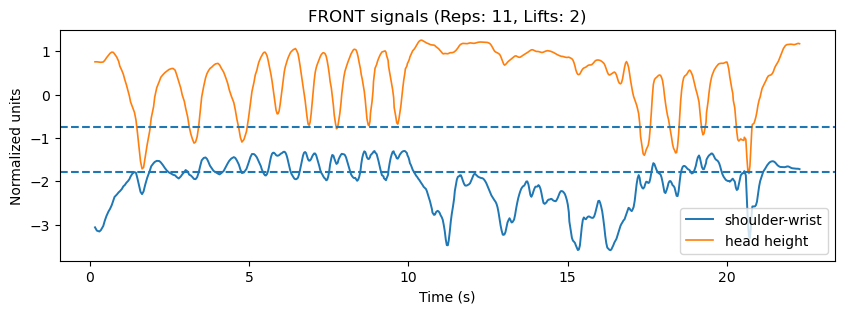

{'predicted_reps': 11, 'ground_truth_reps': 12, 'abs_error': 1, 'pct_error': 8.333333333333334}


In [8]:
# ---- Form stats summary & error ----
def pct(a,b): return (100.0*a/max(1,b))
lockout_pct = pct(frames_up_lock, frames_up)
depth_pct   = pct(frames_down_depth, frames_down)

print(f"[RESULT] Reps: {rep_count}")
print(f"[FORM]   Lockout frames: {frames_up_lock}/{frames_up} ({lockout_pct:.1f}%)")
print(f"[FORM]   Depth frames:   {frames_down_depth}/{frames_down} ({depth_pct:.1f}%)")
print(f"[REST]   Hand lifts detected: {hand_lift_counter}")
if mode == "FRONT":
    print(f"[THRESHOLDS FRONT] DOWN={DOWN_THRESH_F:.3f}, UP={UP_THRESH_F:.3f}")
else:
    print(f"[THRESHOLDS SIDE ] DOWN={DOWN_THRESH_S:.1f}, UP={UP_THRESH_S:.1f}")

gt = GROUND_TRUTH_REPS
abs_err = abs(rep_count - gt)
pct_err = 100.0*abs_err/max(1, gt)
print({"predicted_reps": rep_count, "ground_truth_reps": gt, "abs_error": abs_err, "pct_error": round(pct_err,1)})

# ---- Post-run plot (for sanity) ----
if PLOT_AFTER and time_stamps:
    plt.figure(figsize=(10,3))
    if mode == "FRONT":
        plt.plot(time_stamps, safe_savgol(sig_sw, win=SMOOTH_WIN, poly=3), linewidth=1.4, label="shoulder-wrist")
        plt.plot(time_stamps, safe_savgol(sig_head, win=SMOOTH_WIN, poly=3), linewidth=1.2, label="head height")
        plt.axhline(UP_THRESH_F, linestyle="--")
        plt.axhline(DOWN_THRESH_F, linestyle="--")
        plt.title(f"FRONT signals (Reps: {rep_count}, Lifts: {hand_lift_counter})")
        plt.xlabel("Time (s)"); plt.ylabel("Normalized units"); plt.legend()
    else:
        plt.plot(time_stamps, safe_savgol(sig_angle, win=SMOOTH_WIN, poly=3), linewidth=1.4, label="elbow angle (deg)")
        plt.axhline(UP_THRESH_S, linestyle="--")
        plt.axhline(DOWN_THRESH_S, linestyle="--")
        plt.title(f"SIDE signal (Reps: {rep_count}, Lifts: {hand_lift_counter})")
        plt.xlabel("Time (s)"); plt.ylabel("Degrees"); plt.legend()
    plt.show()

ground_truth_reps = 12
pred = len(rep_marks)
print({
    "predicted_reps": pred,
    "ground_truth_reps": ground_truth_reps,
    "abs_error": abs(pred - ground_truth_reps),
    "pct_error": 100.0 * abs(pred - ground_truth_reps) / max(1, ground_truth_reps)
})